# LOADING THE NECESSARY PACKAGES

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pandas as pd
import hdbscan
from sklearn.preprocessing import OneHotEncoder
import random



import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

In [2]:
#Load the champo dataset
file_path = 'C:/Users/admin/Downloads/Champo Carpets V1.csv'
df = pd.read_csv(file_path)

## Creating the features as specified

In [3]:
# Total number of quantities ordered for each item
total_quantities = df.groupby('Item_Id')['QtyRequired'].sum().rename('TotalQuantitiesOrdered')

# Total revenue generated by each item
total_revenue = df.groupby('Item_Id')['Amount'].sum().rename('TotalRevenueGenerated')

# Number of unique customer orders for each item
num_customer_orders = df.groupby('Item_Id')['CustomerCode'].nunique().rename('NumberOfCustomerOrders')

# Average number of quantities per order for each item
average_qty_per_order = (df.groupby('Item_Id')['QtyRequired'].sum() / 
                         df.groupby('Item_Id')['OrderiD'].nunique()).rename('AverageQuantityPerOrder')

# Intuitive Feature 1: Revenue per area unit for each item (TotalRevenueGenerated/TotalArea)
revenue_per_area = (df.groupby('Item_Id')['Amount'].sum() / 
                    df.groupby('Item_Id')['TotalArea'].sum()).rename('RevenuePerAreaUnit')

# Intuitive Feature 2: Average price per unit quantity for each item (TotalRevenueGenerated/TotalQuantitiesOrdered)
avg_price_per_unit = (df.groupby('Item_Id')['Amount'].sum() / 
                      df.groupby('Item_Id')['QtyRequired'].sum()).rename('AveragePricePerUnit')

# Combining all features into a single DataFrame
item_features = pd.DataFrame({
    'TotalQuantitiesOrdered': total_quantities,
    'TotalRevenueGenerated': total_revenue,
    'NumberOfCustomerOrders': num_customer_orders,
    'AverageQuantityPerOrder': average_qty_per_order,
    'RevenuePerAreaUnit': revenue_per_area,
    'AveragePricePerUnit': avg_price_per_unit
})

# Display the DataFrame with the new features
item_features.head()

,TotalQuantitiesOrdered,TotalRevenueGenerated,NumberOfCustomerOrders,AverageQuantityPerOrder,RevenuePerAreaUnit,AveragePricePerUnit
Item_Id,,,,,,
1,2,12.00,1,2.0,2.0,6.00
2,2,18.00,1,2.0,2.0,9.00
3,7,378.00,1,3.5,3.5,54.00
4,9,641.25,1,4.5,4.5,71.25
5,22,2821.50,1,11.0,11.0,128.25


In [4]:
# Scaling the features
scaler = StandardScaler()
item_features_scaled = scaler.fit_transform(item_features)

## Applying K-Means

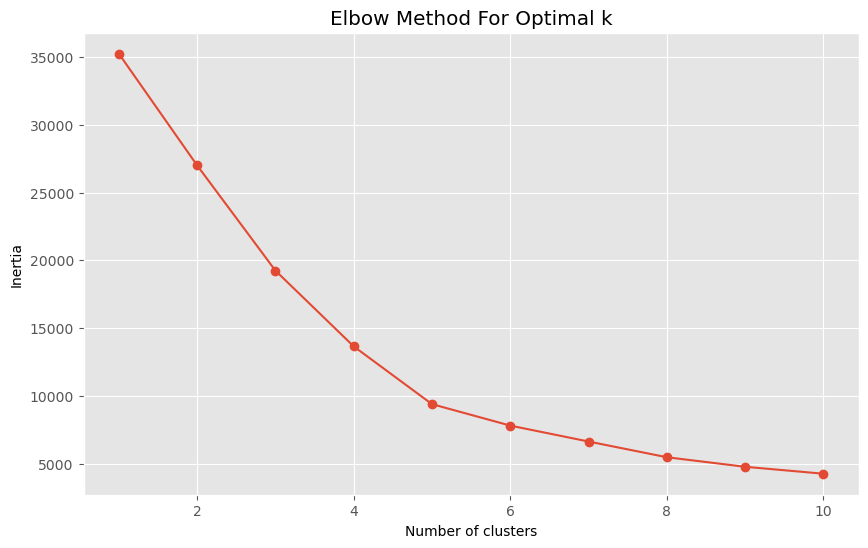

In [5]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(item_features_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [6]:
kmeans = KMeans(n_clusters=5, random_state=42)
item_features['ClusterID'] = kmeans.fit_predict(item_features_scaled)

item_features['ClusterID'] = kmeans.labels_

item_features.head()


,TotalQuantitiesOrdered,TotalRevenueGenerated,NumberOfCustomerOrders,AverageQuantityPerOrder,RevenuePerAreaUnit,AveragePricePerUnit,ClusterID
Item_Id,,,,,,,
1,2,12.00,1,2.0,2.0,6.00,2
2,2,18.00,1,2.0,2.0,9.00,2
3,7,378.00,1,3.5,3.5,54.00,2
4,9,641.25,1,4.5,4.5,71.25,2
5,22,2821.50,1,11.0,11.0,128.25,2


## Segmenting

In [7]:
# Calculating the centroids for each cluster
cluster_centroids = item_features.groupby('ClusterID').mean()

# Counting the number of items in each cluster
cluster_counts = item_features['ClusterID'].value_counts().sort_index()

# Combining the centroid and count information into a single DataFrame for analysis
cluster_analysis = cluster_centroids.join(cluster_counts.to_frame(name='ItemCount'))

# Analyzing the clusters to interpret the characteristics
cluster_analysis['SegmentName'] = pd.Series(dtype='str')
for cluster_id, cluster_row in cluster_analysis.iterrows():
    if cluster_row['TotalRevenueGenerated'] > cluster_analysis['TotalRevenueGenerated'].mean():
        cluster_analysis.at[cluster_id, 'SegmentName'] = 'High Revenue'
    elif cluster_row['TotalQuantitiesOrdered'] > cluster_analysis['TotalQuantitiesOrdered'].mean():
        cluster_analysis.at[cluster_id, 'SegmentName'] = 'High Quantity'
    else:
        cluster_analysis.at[cluster_id, 'SegmentName'] = 'General'

cluster_analysis


,TotalQuantitiesOrdered,TotalRevenueGenerated,NumberOfCustomerOrders,AverageQuantityPerOrder,RevenuePerAreaUnit,AveragePricePerUnit,ItemCount,SegmentName
ClusterID,,,,,,,,
0,72.666667,339862.132963,1.000000,8.841774,463.594015,5011.782010,27,High Revenue
1,5111.160000,53808.607600,1.000000,3133.473333,2463.450553,9.060886,25,High Quantity
2,67.516587,3360.627782,1.000000,33.929998,125.942238,118.969390,5637,General
3,220.704762,13244.290154,2.019048,56.144473,91.470819,124.713584,105,General
4,623.259259,6956.117243,1.000000,548.166461,5983.938712,12.840666,81,General


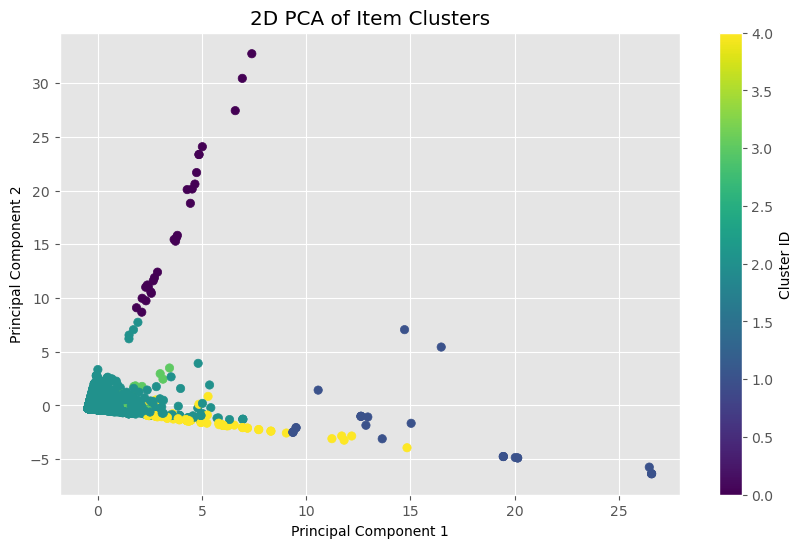

0.8771405484759471

In [8]:
# Calculating the silhouette score for the K-Means clustering
silhouette_avg = silhouette_score(item_features_scaled, item_features['ClusterID'])

# Applying PCA to reduce the scaled features to 2 dimensions for visualization
pca = PCA(n_components=2)
item_features_pca = pca.fit_transform(item_features_scaled)

# Creating a DataFrame for the PCA reduced data
pca_df = pd.DataFrame(data=item_features_pca, columns=['PC1', 'PC2'])
pca_df['ClusterID'] = item_features['ClusterID'].values

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['ClusterID'], cmap='viridis', marker='o')
plt.title('2D PCA of Item Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster ID')
plt.show()

silhouette_avg


## Additional Segmenting

In [9]:
# Calculating the centroids for each cluster
cluster_centroids = item_features.groupby('ClusterID').mean()

# Counting the number of items in each cluster
cluster_counts = item_features['ClusterID'].value_counts().sort_index()

# Combining the centroid and counting information into a single DataFrame for analysis
cluster_analysis = cluster_centroids.join(cluster_counts.to_frame(name='ItemCount'))

# Using qualitative descriptions based on the centroid values of each feature within the cluster
cluster_analysis['SegmentName'] = pd.Series(dtype='str')
for cluster_id, cluster_row in cluster_analysis.iterrows():
    descriptors = []
    if cluster_row['TotalRevenueGenerated'] > cluster_analysis['TotalRevenueGenerated'].mean():
        descriptors.append("High Revenue")
    else:
        descriptors.append("Lower Revenue")

    if cluster_row['TotalQuantitiesOrdered'] > cluster_analysis['TotalQuantitiesOrdered'].mean():
        descriptors.append("High Quantity")
    else:
        descriptors.append("Lower Quantity")

    if cluster_row['TotalRevenueGenerated'] > cluster_analysis['TotalRevenueGenerated'].mean():
        descriptors.append("High Avg Revenue/Order")
    else:
        descriptors.append("Lower Avg Revenue/Order")

    if cluster_row['RevenuePerAreaUnit'] > cluster_analysis['RevenuePerAreaUnit'].mean():
        descriptors.append("High Avg Area/Quantity")
    else:
        descriptors.append("Lower Avg Area/Quantity")
    
    # Joining descriptors with a comma
    cluster_analysis.at[cluster_id, 'SegmentName'] = ', '.join(descriptors)

cluster_analysis[['SegmentName', 'ItemCount']]


,SegmentName,ItemCount
ClusterID,,
0,"High Revenue, Lower Quantity, High Avg Revenue...",27
1,"Lower Revenue, High Quantity, Lower Avg Revenu...",25
2,"Lower Revenue, Lower Quantity, Lower Avg Reven...",5637
3,"Lower Revenue, Lower Quantity, Lower Avg Reven...",105
4,"Lower Revenue, Lower Quantity, Lower Avg Reven...",81


# Product Cluster Based On Purchase Patterns
### Using HDBSCAN

In [10]:
# One-hot encoding the items for each order
one_hot_encoder = OneHotEncoder()
df_encoded = one_hot_encoder.fit_transform(df[['OrderiD', 'Item_Id']])

# Applying HDBSCAN to cluster the one-hot encoded data
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean')
clusters = clusterer.fit_predict(df_encoded)
df['ClusterID'] = clusters

# Displaying some clusters and their items
clustered_items = df.groupby('ClusterID')['Item_Id'].apply(lambda x: x.unique())
for cluster_id in clustered_items.index:
    if cluster_id != -1:  # Excluding noise points
        print(f"Cluster {cluster_id}: {clustered_items[cluster_id]}")


Cluster 0: [36506 36508 36513 36509 36507 36514 36503 36510 36505 36512 36504 36511
 36528 36529 36525 36526 38006 38008 38007 38005 38009 38004 38331 38329
 38325 38328 38330 36527 38324]
Cluster 1: [37402 37403 37404 37405 37406 37407 37401]
Cluster 2: [37317 37316 37318 37325 37324 37319 37315 37323 37314 37322 37313 37321
 37312 37320]
Cluster 3: [2195 2194 2193 2196 2191 2192]
Cluster 4: [23806 23805 23807 23800 23801 23804 23803 23802 23799]
Cluster 5: [7918 7923 7924 7922 7921 7919 7920 7925]
Cluster 6: [38127 38130 38128 38129 38125 38126]
Cluster 7: [38154 38152 38157]
Cluster 8: [38425 38426 38424 38427 38429 38421 38422 38428 38423]
Cluster 9: [35984 35985 35986 35987 35975 35976 35977 35978 40529 40530 40524 40525
 40528 40523 40526 40527 39131 39113 39117 39122]
Cluster 10: [34470 37943 38108 38109 38106 38107 38105]
Cluster 11: [44401 44402 44403 44400]
Cluster 12: [45772 45901 45872 45874 45875 45881 45883 45885 45897 45898 45899 45900
 45848 45871 45873 45880 45882 4588

In [11]:
cluster_sizes = clustered_items.apply(len)

# Displaying the largest clusters
print("Largest Clusters:")
largest_cluster_ids = cluster_sizes.nlargest(3).index
for cluster_id in largest_cluster_ids:
    print(f"Cluster {cluster_id}: {clustered_items[cluster_id]}")

# Displaying the smallest clusters
print("\nSmallest Clusters:")
smallest_cluster_ids = cluster_sizes.nsmallest(3).index
for cluster_id in smallest_cluster_ids:
    print(f"Cluster {cluster_id}: {clustered_items[cluster_id]}")

# Displaying random clusters
print("\nRandom Clusters:")
random_clusters = random.sample(list(clustered_items.index), 3)
for cluster_id in random_clusters:
    print(f"Cluster {cluster_id}: {clustered_items[cluster_id]}")


Largest Clusters:
Cluster 107: [ 2308  2304  2311  2488    83  2356  2355  1289  2451  2478   100  1161
  1218  1286  1455  1227  1399  2429   101  1486  1443    77  1226  1444
  2457  1780  1225  2435    84  1436  1224  1229  2366  2495  1164  1440
  1453  2319  2475  1445   109  2434  1442  1448  1230  1458  2428  1228
  1400  1454    70  2487  2499  1679  3261  1677    65  1095  1674  3291
  3277  1682  1678  1113  1675  3275  3302  1092    61  3290  1116  3262
  3274  1681    64  1091  1104  3292  1115  3289  1094  1110  1114  3258
  2456  1412    81  1409  3303    89  1413  2481  1151  3410  1210  2380
  2398  3397    74  1420  1450  2377  3426  2409   102  1485  3311  3319
  1155  1406  1457  3304  1407  3413  1509  3308  3346  2438  1220  2455
  1136  1221    73  1284  1287  2454    82  2464  1449  2471  1446  1483
  1784  2469  2500  1265  1779  2450    69  3700  1082   105  1281  3423
  3334  1213  1222  3414  3375  3369  3424  3320  3323  3429  3378  3377
  3388  3416  3328  